In this notebook we will train a Variational Auto-Encoder VAE, which will (hopefully) translate all UI images into some n-dimensional space, in which we can then do the optimising.

We will use [https://github.com/AntixK/PyTorch-VAE](https://github.com/AntixK/PyTorch-VAE/tree/master) as a basis.

In [1]:
!nvidia-smi

Thu Jun 20 07:53:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080        On  | 00000000:85:00.0 Off |                  N/A |
| 27%   28C    P8               6W / 180W |      1MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [55]:
!pip install -q huggingface_hub loguru accelerate torchsummary

In [56]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
from os import listdir
from os.path import isfile, join
import json
from utils import calculate_initial_theta, stack_alpha_aware, transform_to_t
import utils
from math import prod
from loguru import logger
import matplotlib.pyplot as plt
import torch
from PIL import Image
import random
from huggingface_hub import hf_hub_download
from torchsummary import summary

Tensor = TypeVar('torch.tensor')

In [7]:
import torchvision.transforms as T
from torchvision import datasets, transforms
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])

In [8]:
resnet_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
from torch import nn
from torch.utils.data import Dataset
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError
    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

Proposed in_channels:

Almost all UIs will have 3 Buttons and 3 `FIXME` objects. So we will input an ordered list into it of the respective normalised (between 0 and 1) positions.

In [10]:
def get_all_clickable_resources(item, should_be_clickable):
    if item is None:
        return []
    all_boxes = []
    if "bounds" in item.keys() and "resource-id" in item.keys() and "clickable" in item.keys() and item["clickable"]==should_be_clickable and item["visible-to-user"]:
        all_boxes.append((item["bounds"],item["resource-id"]))
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_clickable_resources(child,should_be_clickable):
                all_boxes.append(box)
    return all_boxes

def get_all_bounding_boxes(item, should_be_clickable):
    bboxes = get_all_clickable_resources(item,should_be_clickable)
    reduced_bboxes = []
    already_seen_ids = []
    for box,r_id in bboxes:
        if r_id not in already_seen_ids:
            reduced_bboxes.append(box)
            already_seen_ids.append(r_id)
    return reduced_bboxes


In [11]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/jovyan/work/bachelorthesis/utils.py'>

In [12]:
NORMAL_UI_DIMENSIONS = (1440, 2560)

def combine_list_of_lists(a,b):
    assert len(a) == len(b)
    lol = []
    for x in range(len(a)):
        assert len(a[x]) == len(a[x])
        i = []
        for h in range(len(a[x])):
            i.append(a[x][h])
        for h in range(len(b[x])):
            i.append(b[x][h])
        lol.append(i)
    return lol

class CustomRicoDataset(Dataset):
    def __init__(self, combined_path="./combined", return_metadata=False, forward_to_next_index_on_error=False):
        self.image_files = [
            f
            for f in listdir(combined_path)
            if isfile(join(combined_path, f)) and ("jpg" in f or "jpeg" in f)
        ]
        self.combined_path = combined_path
        self.return_metadata = return_metadata
        self.forward_to_next_index_on_error = forward_to_next_index_on_error

        self.get_first_n_clickable = 4
        self.get_first_n_non_clickable = 3

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = join(self.combined_path,self.image_files[idx])
        image = Image.open(img_path)

        json_path = join(self.combined_path,self.image_files[idx].split(".")[0]+".json")
        with open(json_path, "r") as f:
            image_json = json.load(f)

        
        if not self.forward_to_next_index_on_error:
            clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_clickable, True)
            non_clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_non_clickable, False)
        else:
            try:
                clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_clickable, True)
                non_clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_non_clickable, False)
            except ValueError:
                if idx == (len(self)-1):
                    return self[idx-100]
                return self[idx+1]
                
        combined_elems = combine_list_of_lists(clickable_elems, non_clickable_elems)
        
        if self.return_metadata:
            return [combined_elems[0], torch.tensor(combined_elems[1]), combined_elems[2]], img_path
        else:
            return torch.tensor(combined_elems[1])

In [13]:
dataset = CustomRicoDataset("../combined", forward_to_next_index_on_error=True)

In [14]:
if False:
    okay_points = 0
    not_okay_points = 0
    indexes = list(range(len(dataset)))
    random.shuffle(indexes)
    for x in tqdm(indexes):
        try:
            _ = dataset[sample_idx]
            okay_points += 1
        except ValueError:
            print(f"{x}: Not okay")
            not_okay_points += 1
    okay_points, not_okay_points        

In [15]:
sample_idx = torch.randint(len(dataset), size=(1,)).item()
j = dataset[sample_idx]

In [16]:
j.shape

torch.Size([7, 4])

In [32]:
j

tensor([[0.0000, 0.1750, 0.5000, 0.2812],
        [0.6500, 0.0383, 0.1167, 0.0656],
        [0.7667, 0.0383, 0.1167, 0.0656],
        [0.8833, 0.0383, 0.1167, 0.0656],
        [0.0000, 0.1750, 1.0000, 0.7594],
        [0.0000, 0.0328, 1.0000, 0.0766],
        [0.0000, 0.1094, 1.0000, 0.0656]])

In [39]:
j.unsqueeze(0).flatten(start_dim=1)

tensor([[0.0000, 0.1750, 0.5000, 0.2812, 0.6500, 0.0383, 0.1167, 0.0656, 0.7667,
         0.0383, 0.1167, 0.0656, 0.8833, 0.0383, 0.1167, 0.0656, 0.0000, 0.1750,
         1.0000, 0.7594, 0.0000, 0.0328, 1.0000, 0.0766, 0.0000, 0.1094, 1.0000,
         0.0656]])

In [141]:
import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *


class VanillaVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        # Number of elems that have been chosen previously
        self.n_elems = 7

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    #nn.Conv2d(in_channels, out_channels=h_dim,
                    #          kernel_size= 3, stride= 2, padding  = 1),
                    nn.Linear(in_channels, h_dim),
                    # nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*self.n_elems, latent_dim)
        # self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*self.n_elems, latent_dim)
        # self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        print(hidden_dims, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.n_elems)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    #nn.ConvTranspose2d(hidden_dims[i],
                    #                   hidden_dims[i + 1],
                    #                   kernel_size=3,
                    #                   stride = 2,
                    #                   padding=1,
                    #                   output_padding=1),
                    #nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            #nn.ConvTranspose2d(hidden_dims[-1],
                            #                   hidden_dims[-1],
                            #                   kernel_size=3,
                            #                   stride=2,
                            #                   padding=1,
                            #                   output_padding=1),
                            #nn.BatchNorm2d(hidden_dims[-1]),
                            nn.Linear(hidden_dims[-1],hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1],4),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.n_elems, 512)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons[:,:,:2], input[:,:,:2])


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [142]:
vae = VanillaVAE(in_channels=4, latent_dim=32)
# vae = vae.to(accelerator.device)

[32, 64, 128, 256, 512] 32


In [143]:
vae.fc_mu.weight.shape

torch.Size([32, 3584])

In [144]:
j.shape

torch.Size([7, 4])

In [145]:
j.unsqueeze(0).flatten(start_dim=1).shape

torch.Size([1, 28])

In [146]:
vae.encoder(j.unsqueeze(0)).shape

torch.Size([1, 7, 512])

In [147]:
recons, inp, mu, log_var = vae.forward(j.unsqueeze(0))

In [148]:
vae.encode(j.unsqueeze(0))[0].shape

torch.Size([1, 32])

In [149]:
recons.shape

torch.Size([1, 7, 4])

In [150]:
inp.shape

torch.Size([1, 7, 4])

In [151]:
loss = vae.loss_function(recons,inp,mu,log_var, M_N=1)

In [152]:
loss

{'loss': tensor(0.1291, grad_fn=<AddBackward0>),
 'Reconstruction_Loss': tensor(0.1193),
 'KLD': tensor(-0.0097)}

In [153]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from accelerate import Accelerator

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [154]:
accelerator = Accelerator()

In [155]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25, verbose = True)

In [156]:
vae, optimizer, train_dataloader, scheduler = accelerator.prepare(vae, optimizer, train_dataloader, scheduler)

In [157]:
vae

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=3584, out_features=32, bias=True)
  (fc_var): Linear(in_features=3584, out_features=32, bias=True)
  (decoder_input): Linear(in_features=32, out_features=3584, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, 

In [158]:
force_retrain = True
losses = []
if not isfile("./vae_pretrained") or force_retrain:
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # j_tensor = .to(accelerate)
        # print(batch)
        recons, inp, mu, log_var = vae.forward(batch)
        loss = vae.loss_function(recons,inp,mu,log_var, M_N=64)
        # loss["loss"].backward()
        
        accelerator.backward(loss["loss"])
    
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.5)
    
        
        optimizer.step()
        
        # logger.info(f"{loss['loss'].item()}, lr: {scheduler.get_last_lr()[0]}")
        logger.info(f"[{str(idx).zfill(3)}] {loss['loss'].item()}")
        losses.append(loss["loss"].detach().cpu().item())
        scheduler.step(loss["loss"])
    torch.save(vae.state_dict(), "./vae_pretrained")
else:
    vae.load_state_dict(torch.load("./vae_pretrained"))
    vae.eval()

  0%|          | 0/518 [00:00<?, ?it/s]

2024-06-20 10:36:28.020 | INFO     | __main__:<module>:19 - [000] 0.8267968893051147
2024-06-20 10:38:08.928 | INFO     | __main__:<module>:19 - [001] 146.20968627929688
2024-06-20 10:39:43.558 | INFO     | __main__:<module>:19 - [002] 19.14206886291504
2024-06-20 10:41:20.976 | INFO     | __main__:<module>:19 - [003] 7.408414363861084
2024-06-20 10:42:55.534 | INFO     | __main__:<module>:19 - [004] 0.798427402973175
2024-06-20 10:44:30.839 | INFO     | __main__:<module>:19 - [005] 1.7210686206817627
2024-06-20 10:46:10.533 | INFO     | __main__:<module>:19 - [006] 0.6640815138816833
2024-06-20 10:47:48.077 | INFO     | __main__:<module>:19 - [007] 0.3340248465538025
2024-06-20 10:49:21.980 | INFO     | __main__:<module>:19 - [008] 0.6612845063209534
2024-06-20 10:50:56.530 | INFO     | __main__:<module>:19 - [009] 0.310728520154953
2024-06-20 10:52:33.531 | INFO     | __main__:<module>:19 - [010] 0.33455249667167664
2024-06-20 10:54:11.853 | INFO     | __main__:<module>:19 - [011] 0.

In [ ]:
inp.shape

In [ ]:
recons.shape

In [ ]:
batch.shape

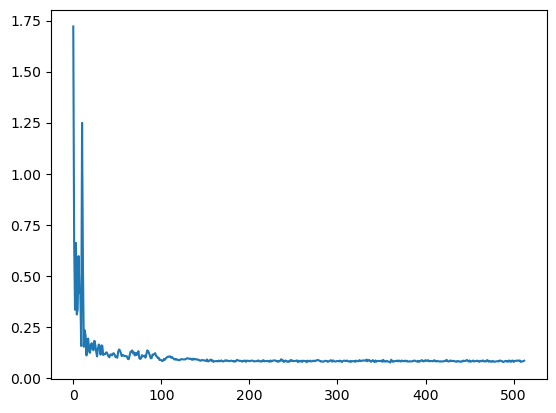

In [159]:
if losses:
    plt.plot(losses[5:])
    plt.show()

In [160]:
if losses:
    print(losses[-1])

0.08408566564321518


In [161]:
dataset[0].shape

torch.Size([7, 4])

In [52]:
recons, inp, mu, log_var = vae.forward(dataset[100].to(accelerator.device))
z = vae.reparameterize(mu, log_var)

In [53]:
inp

tensor([[[0.0000, 0.8742, 1.0000, 0.0602],
         [0.0000, 0.1402, 0.7056, 0.0602],
         [0.0194, 0.6609, 0.8396, 0.0355],
         [0.0243, 0.2945, 0.1556, 0.0574],
         [0.0000, 0.9344, 1.0000, 0.0656],
         [0.0243, 0.2355, 0.9514, 0.0480],
         [0.0000, 0.0000, 1.0000, 0.0328]]], device='cuda:0')

In [54]:
recons

tensor([[[0.1586, 0.3489, 0.6682, 0.0949],
         [0.2397, 0.3728, 0.5072, 0.0808],
         [0.3247, 0.3864, 0.3848, 0.0789],
         [0.3823, 0.3866, 0.3158, 0.0739],
         [0.0993, 0.3721, 0.8180, 0.1131],
         [0.0814, 0.4016, 0.8280, 0.0933],
         [0.1599, 0.3706, 0.6632, 0.0763]]], device='cuda:0',
       grad_fn=<TanhBackward0>)

In [55]:
z

tensor([[ 0.1622, -1.8633,  0.2063,  0.7812,  1.3603, -0.0648,  0.6211, -0.3528,
         -0.3424,  0.0388, -0.5514, -0.0521, -0.4820, -0.2650,  1.3785, -0.9116,
          0.7687, -0.9951, -0.9940,  0.1535,  0.2508,  0.5493, -2.7327,  0.3602,
          0.7916, -0.1576,  1.1930,  1.9058, -1.2872, -0.7226,  0.1114,  1.8544]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [56]:
# We need to modify this function to avoid np conversions and differentiation problems
def calculate_initial_theta(segment, canvas_size, original_position):
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    # grid_location_x and grid_location_y are basically percentages of height and width and not actual coordinates
    # Because we already warp the segment onto a bigger canvas, this transformation is a bit complicated
    # grid_location_x has to be in the interval [-(x_ratio-1),(x_ratio-1)], i.e. 0 means -(x_ratio - 1) and 1440 means (x_ratio - 1)
    # We can map U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b
    # We first map U ~ [0, max_width] to U ~ [0,1] by dividing by max_width

    eps = 0.00001 # Avoid div by zero
    original_x_position = (original_position[0]) / (canvas_size[0]-segment.size[0]+eps)
    mapped_x_position = (-(x_ratio - 1) - (x_ratio - 1))*original_x_position + (x_ratio-1)

    original_y_position = (original_position[1]) / (canvas_size[1]-segment.size[1]+eps)
    mapped_y_position = (-(y_ratio - 1) - (y_ratio - 1))*original_y_position + (y_ratio-1)

    theta = torch.tensor([
        [0.0,0.0,0.0],
        [0.0,0.0,0.0]
    ]).to(accelerator.device)
    
    theta[0][0] += x_ratio
    theta[1][1] += y_ratio
    theta[0][2] += mapped_x_position
    theta[1][2] += mapped_y_position
    
    #return np.array([
    #    [x_ratio, 0.0    , mapped_x_position],
    #    [0.0    , y_ratio, mapped_y_position]
    #])
    return theta

In [57]:
class MultivariateNormalPDF(nn.Module):
    def __init__(self, mean, covariance, device):
        super(MultivariateNormalPDF, self).__init__()
        self.mean = mean.to(device)
        self.covariance = covariance.to(device)
        self.inv_covariance = torch.inverse(covariance).to(device)
        self.det_covariance = torch.det(covariance).to(device)
        self.dim = mean.size(0)
        self.const = torch.sqrt((2 * torch.pi) ** self.dim * self.det_covariance).to(device)
    
    def forward(self, x):
        diff = x - self.mean
        exp_term = -0.5 * torch.sum(diff @ self.inv_covariance * diff, dim=1)
        return torch.exp(exp_term) / self.const

class MultivariateNormalLoss(nn.Module):
    def __init__(self, mean, covariance, device="cpu"):
        super(MultivariateNormalLoss, self).__init__()
        self.pdf = MultivariateNormalPDF(mean, covariance,device)
        self.pdf = self.pdf.to(device)
    
    def forward(self, x):
        pdf_values = self.pdf(x)
        print(pdf_values)
        nll = -torch.log(pdf_values + 1e-8)  # Adding epsilon to prevent log(0)
        print(nll)
        return nll.mean()

from torch.distributions import MultivariateNormal
def multivariate_normal_pdf(x, mean, cov):
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    # return log prob for numerical stability
    return -dist.log_prob(x)
    # return torch.exp(dist.log_prob(x)) 

In [165]:
class GradientDescent(torch.nn.Module):
    def __init__(self, z, segments, device):
        super().__init__()
        # self.vae = vae
        self.z = torch.nn.Parameter(z.to(device))
        # self.vae = self.vae.eval().to(device)
        self.segments = segments
        self.device = device
        
        self.canvas_size = (1,3,NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0])
        self.mean = torch.zeros(self.z.shape[1]).to(self.device)
        
        #print(f"Mean shape: {self.mean.shape}")
        
        self.cov = torch.eye(z.shape[1]).to(self.device)
        
        #print(f"Cov shape: {self.cov.shape}")
        
        # self.mn_loss = MultivariateNormalLoss(self.mean, self.cov, self.device)
        self.mn_loss = lambda x: multivariate_normal_pdf(x, self.mean, self.cov)

    def forward(self, vae, aesthetics_predictor):
        decoded = vae.decode(self.z)[:,:,:2]
        decoded_denormalised = decoded * torch.tensor([NORMAL_UI_DIMENSIONS[0],NORMAL_UI_DIMENSIONS[1]]).to(self.device)

        red = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
        green = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
        blue = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
        alpha = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        
        segments_on_canvas = [background]
        
        for n in range(len(self.segments)):
            theta = calculate_initial_theta(self.segments[n],NORMAL_UI_DIMENSIONS,decoded_denormalised[0][n]) 
            theta = theta.unsqueeze(0).to(self.device)

            if self.device == "cpu":
                grid = F.affine_grid(theta, self.canvas_size).type(torch.FloatTensor)
            else:
                grid = F.affine_grid(theta, self.canvas_size).type(torch.FloatTensor).to(self.device)
            x = F.grid_sample(transform_to_t(self.segments[n]).unsqueeze(0).to(self.device), grid)
            segments_on_canvas.append(x)

        generated_image = stack_alpha_aware(segments_on_canvas)
        generated_image = generated_image[:3]

        transformed_im = resnet_transform(generated_image.unsqueeze(0))
        
        score = aesthetics_predictor(transformed_im)

        mn_loss = self.mn_loss(self.z)
            
        return score, generated_image, mn_loss, transformed_im

In [166]:
test_dataset = CustomRicoDataset("../combined", return_metadata=True, forward_to_next_index_on_error=True)

In [167]:
test_dataset.image_files[0]

'70987.jpg'

In [168]:
dataset_index = 9292

In [169]:
[bboxes, normalized_positions, segments], path = test_dataset[dataset_index]

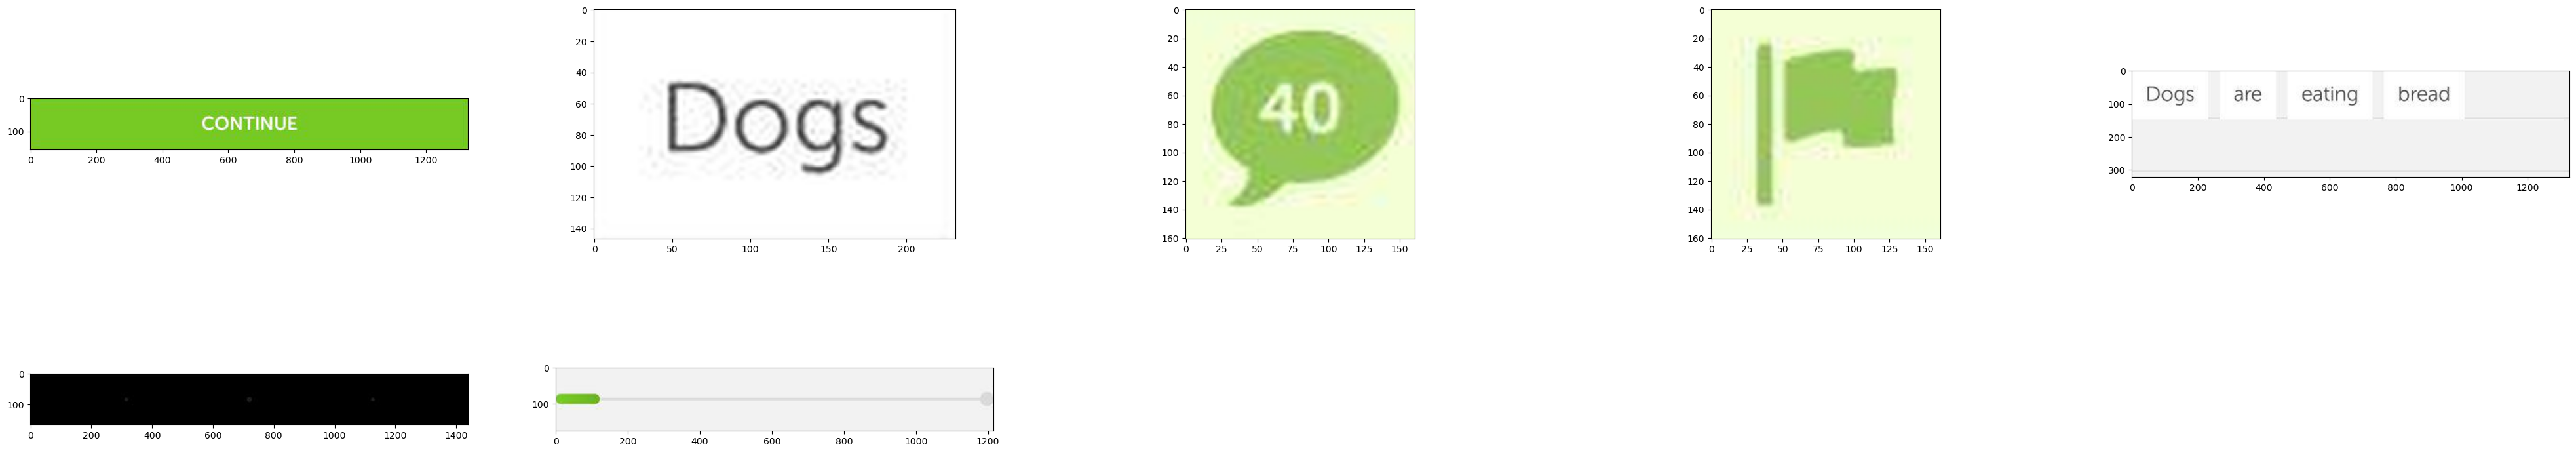

In [170]:
fig = plt.figure(figsize=(50,10))
a = 1
for i in segments:
    fig.add_subplot(2,5,a)
    plt.imshow(i)
    a+=1
plt.show()

In [171]:
appsthetics_predictor = torch.load("../Dataset_estetica/Regressao/model123")

In [172]:
try:
    mu, log_var = vae.encode(normalized_positions.to("cuda"))
except RuntimeError:
    mu, log_var = vae.encode(normalized_positions.to("cpu"))
z = vae.reparameterize(mu, log_var)
# gd = GradientDescent(vae, z, segments, appsthetics_predictor["model"], "cpu")
# gd = GradientDescent(z, segments, appsthetics_predictor["model"], "cpu")
gd = GradientDescent(z, segments, "cpu")

In [173]:
z

tensor([[ 1.2854, -0.2018, -0.3027, -1.2222,  0.2602,  0.6372, -1.7249, -0.5574,
         -1.6597, -1.0440, -0.6638,  0.7687, -0.6794, -0.1401,  0.7445,  1.7496,
          0.1924,  0.3289, -1.0946, -1.4980, -0.8166, -0.1800, -0.0846, -0.2955,
          0.3103, -0.7384,  1.0818,  1.0424, -1.2675, -0.0743, -0.4353,  0.4395]],
       grad_fn=<AddBackward0>)

In [174]:
vae.decode(z.to("cpu"))[:,:,:2]

tensor([[[0.1511, 0.3520],
         [0.2393, 0.3735],
         [0.3259, 0.3862],
         [0.3848, 0.3873],
         [0.0875, 0.3762],
         [0.1037, 0.3902],
         [0.1573, 0.3689]]], grad_fn=<SliceBackward0>)

In [175]:
vae.decode(z.to("cpu"))

tensor([[[0.1511, 0.3520, 0.6795, 0.0886],
         [0.2393, 0.3735, 0.5079, 0.0796],
         [0.3259, 0.3862, 0.3818, 0.0788],
         [0.3848, 0.3873, 0.3144, 0.0745],
         [0.0875, 0.3762, 0.8396, 0.1172],
         [0.1037, 0.3902, 0.7856, 0.0868],
         [0.1573, 0.3689, 0.6684, 0.0778]]], grad_fn=<TanhBackward0>)

In [176]:
pre_ting_str = str(list(vae.parameters()))

In [177]:
list(gd.parameters())

[Parameter containing:
 tensor([[ 1.2854, -0.2018, -0.3027, -1.2222,  0.2602,  0.6372, -1.7249, -0.5574,
          -1.6597, -1.0440, -0.6638,  0.7687, -0.6794, -0.1401,  0.7445,  1.7496,
           0.1924,  0.3289, -1.0946, -1.4980, -0.8166, -0.1800, -0.0846, -0.2955,
           0.3103, -0.7384,  1.0818,  1.0424, -1.2675, -0.0743, -0.4353,  0.4395]],
        requires_grad=True)]

In [178]:
assert len(list(gd.parameters())) == 1

In [179]:
mean = torch.tensor([0.0]*z.shape[1])
cov = torch.tensor([1.0]*z.shape[1])
covariance = torch.diag(cov)
# loss_fn = MultivariateNormalLoss(mean, covariance, accelerator.device)

In [180]:
pdf = multivariate_normal_pdf(z.to("cpu"), mean, covariance)
print(pdf)
# Negative log-likelihood as loss (smaller PDF, higher loss)
# -torch.mean(torch.log(pdf))

tensor([42.0484], grad_fn=<NegBackward0>)


In [181]:
pdf

tensor([42.0484], grad_fn=<NegBackward0>)

In [182]:
# loss = loss_fn(z)

In [183]:
# loss

In [184]:
vae = vae.to("cpu").eval()

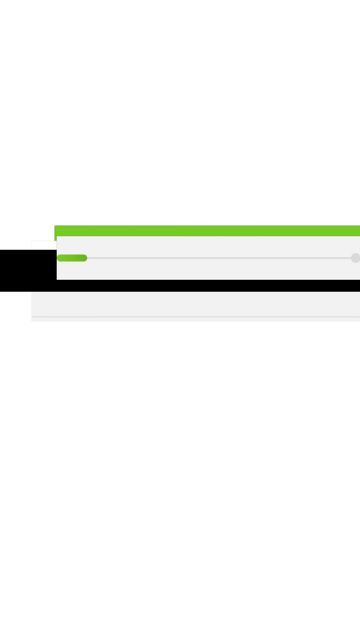

In [185]:
score, img, mn_loss, transformed_img = gd.forward(vae, appsthetics_predictor["model"])
result_pil_before = transform_t_to_pil(img)
display(result_pil_before.resize((int(result_pil_before.size[0]*0.25),int(result_pil_before.size[1]*0.25))))

In [186]:
transformed_img.min()

tensor(-2.1179, grad_fn=<MinBackward1>)

In [187]:
transformed_img[0][0].max()

tensor(2.2489, grad_fn=<MaxBackward1>)

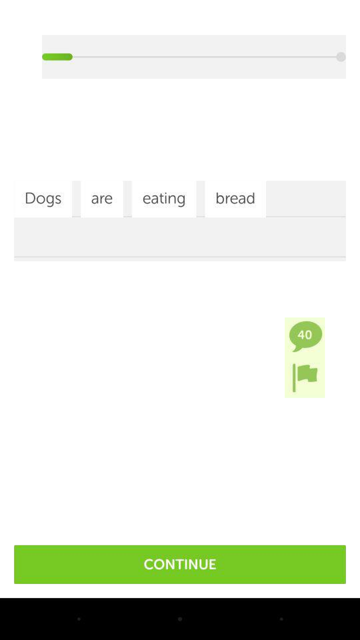

In [188]:
# Sanity check to test if the reassembly work outside of the VAE. If this UI doesnt look right, something is broken

[bboxes, normalized_positions, segments], path = test_dataset[dataset_index]
normalized_positions = normalized_positions[:,:,:2]
canvas_size = (1,3,NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0])
decoded_denormalised = normalized_positions * torch.tensor([NORMAL_UI_DIMENSIONS[0],NORMAL_UI_DIMENSIONS[1]])

red = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
green = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
blue = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
alpha = torch.tile(torch.tensor(1.0),(NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0]))
background = torch.stack([red,green,blue,alpha]).unsqueeze(0)

segments_on_canvas = [background]
        
for n in range(len(segments)):
    theta = calculate_initial_theta(segments[n],NORMAL_UI_DIMENSIONS,decoded_denormalised[0][n]) 
    theta = theta.unsqueeze(0)
    grid = F.affine_grid(theta, canvas_size).type(torch.FloatTensor)
    x = F.grid_sample(transform_to_t(segments[n]).unsqueeze(0), grid)
    segments_on_canvas.append(x)

generated_image = stack_alpha_aware(segments_on_canvas)
generated_image = generated_image[:3]
generated_image = transform_t_to_pil(generated_image)
display(generated_image.resize((int(generated_image.size[0]*0.25),int(generated_image.size[1]*0.25))))

In [190]:
scores = []
all_images = []
all_transformed_images = []
optimiser_gd = torch.optim.AdamW(gd.parameters(),lr=0.05)
iters = 100
for x in range(iters):
    score, image, mn_loss, transformed_img = gd.forward(vae, appsthetics_predictor["model"])
    all_images.append(image)
    all_transformed_images.append(transformed_img)
    score = score[0][0]
    loss = -score
    # loss += mn_loss[0] / 100.0
    logger.info(f"[{x+1}/{iters}] aesthetics score: {score}, mn_loss: {mn_loss.item()}(/100), sum: {loss}")
    loss.backward()
    scores.append(loss.item())
    optimiser_gd.step()

2024-06-19 12:53:16.879 | INFO     | __main__:<module>:13 - [1/5] aesthetics score: 2.657674789428711, mn_loss: 35.93301773071289(/100), sum: -2.657674789428711
2024-06-19 12:53:18.726 | INFO     | __main__:<module>:13 - [2/5] aesthetics score: 2.664128303527832, mn_loss: 36.09295654296875(/100), sum: -2.664128303527832
2024-06-19 12:53:20.539 | INFO     | __main__:<module>:13 - [3/5] aesthetics score: 2.6661362648010254, mn_loss: 36.43452835083008(/100), sum: -2.6661362648010254
2024-06-19 12:53:22.425 | INFO     | __main__:<module>:13 - [4/5] aesthetics score: 2.6567111015319824, mn_loss: 36.824886322021484(/100), sum: -2.6567111015319824
2024-06-19 12:53:24.273 | INFO     | __main__:<module>:13 - [5/5] aesthetics score: 2.6730785369873047, mn_loss: 37.309810638427734(/100), sum: -2.6730785369873047
2024-06-19 12:53:26.066 | INFO     | __main__:<module>:13 - [6/5] aesthetics score: 2.66227388381958, mn_loss: 37.877906799316406(/100), sum: -2.66227388381958
2024-06-19 12:53:27.890 | I

KeyboardInterrupt: 

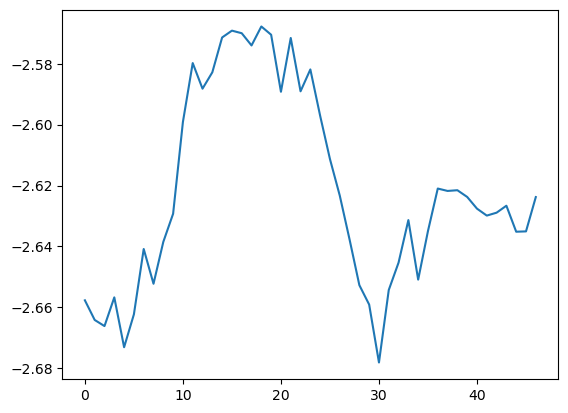

In [191]:
plt.plot(scores)
plt.show()

In [192]:
score, img, pdf_loss, transformed_img = gd.forward(vae, appsthetics_predictor["model"])

In [193]:
img.mean()

tensor(0.9535, grad_fn=<MeanBackward0>)

In [194]:
img.shape

torch.Size([3, 2560, 1440])

In [195]:
score.item(), pdf_loss.item()

(2.6340670585632324, 45.719322204589844)

In [196]:
# display(result_pil_after.resize((int(result_pil_after.size[0]*0.25),int(result_pil_after.size[1]*0.25))))

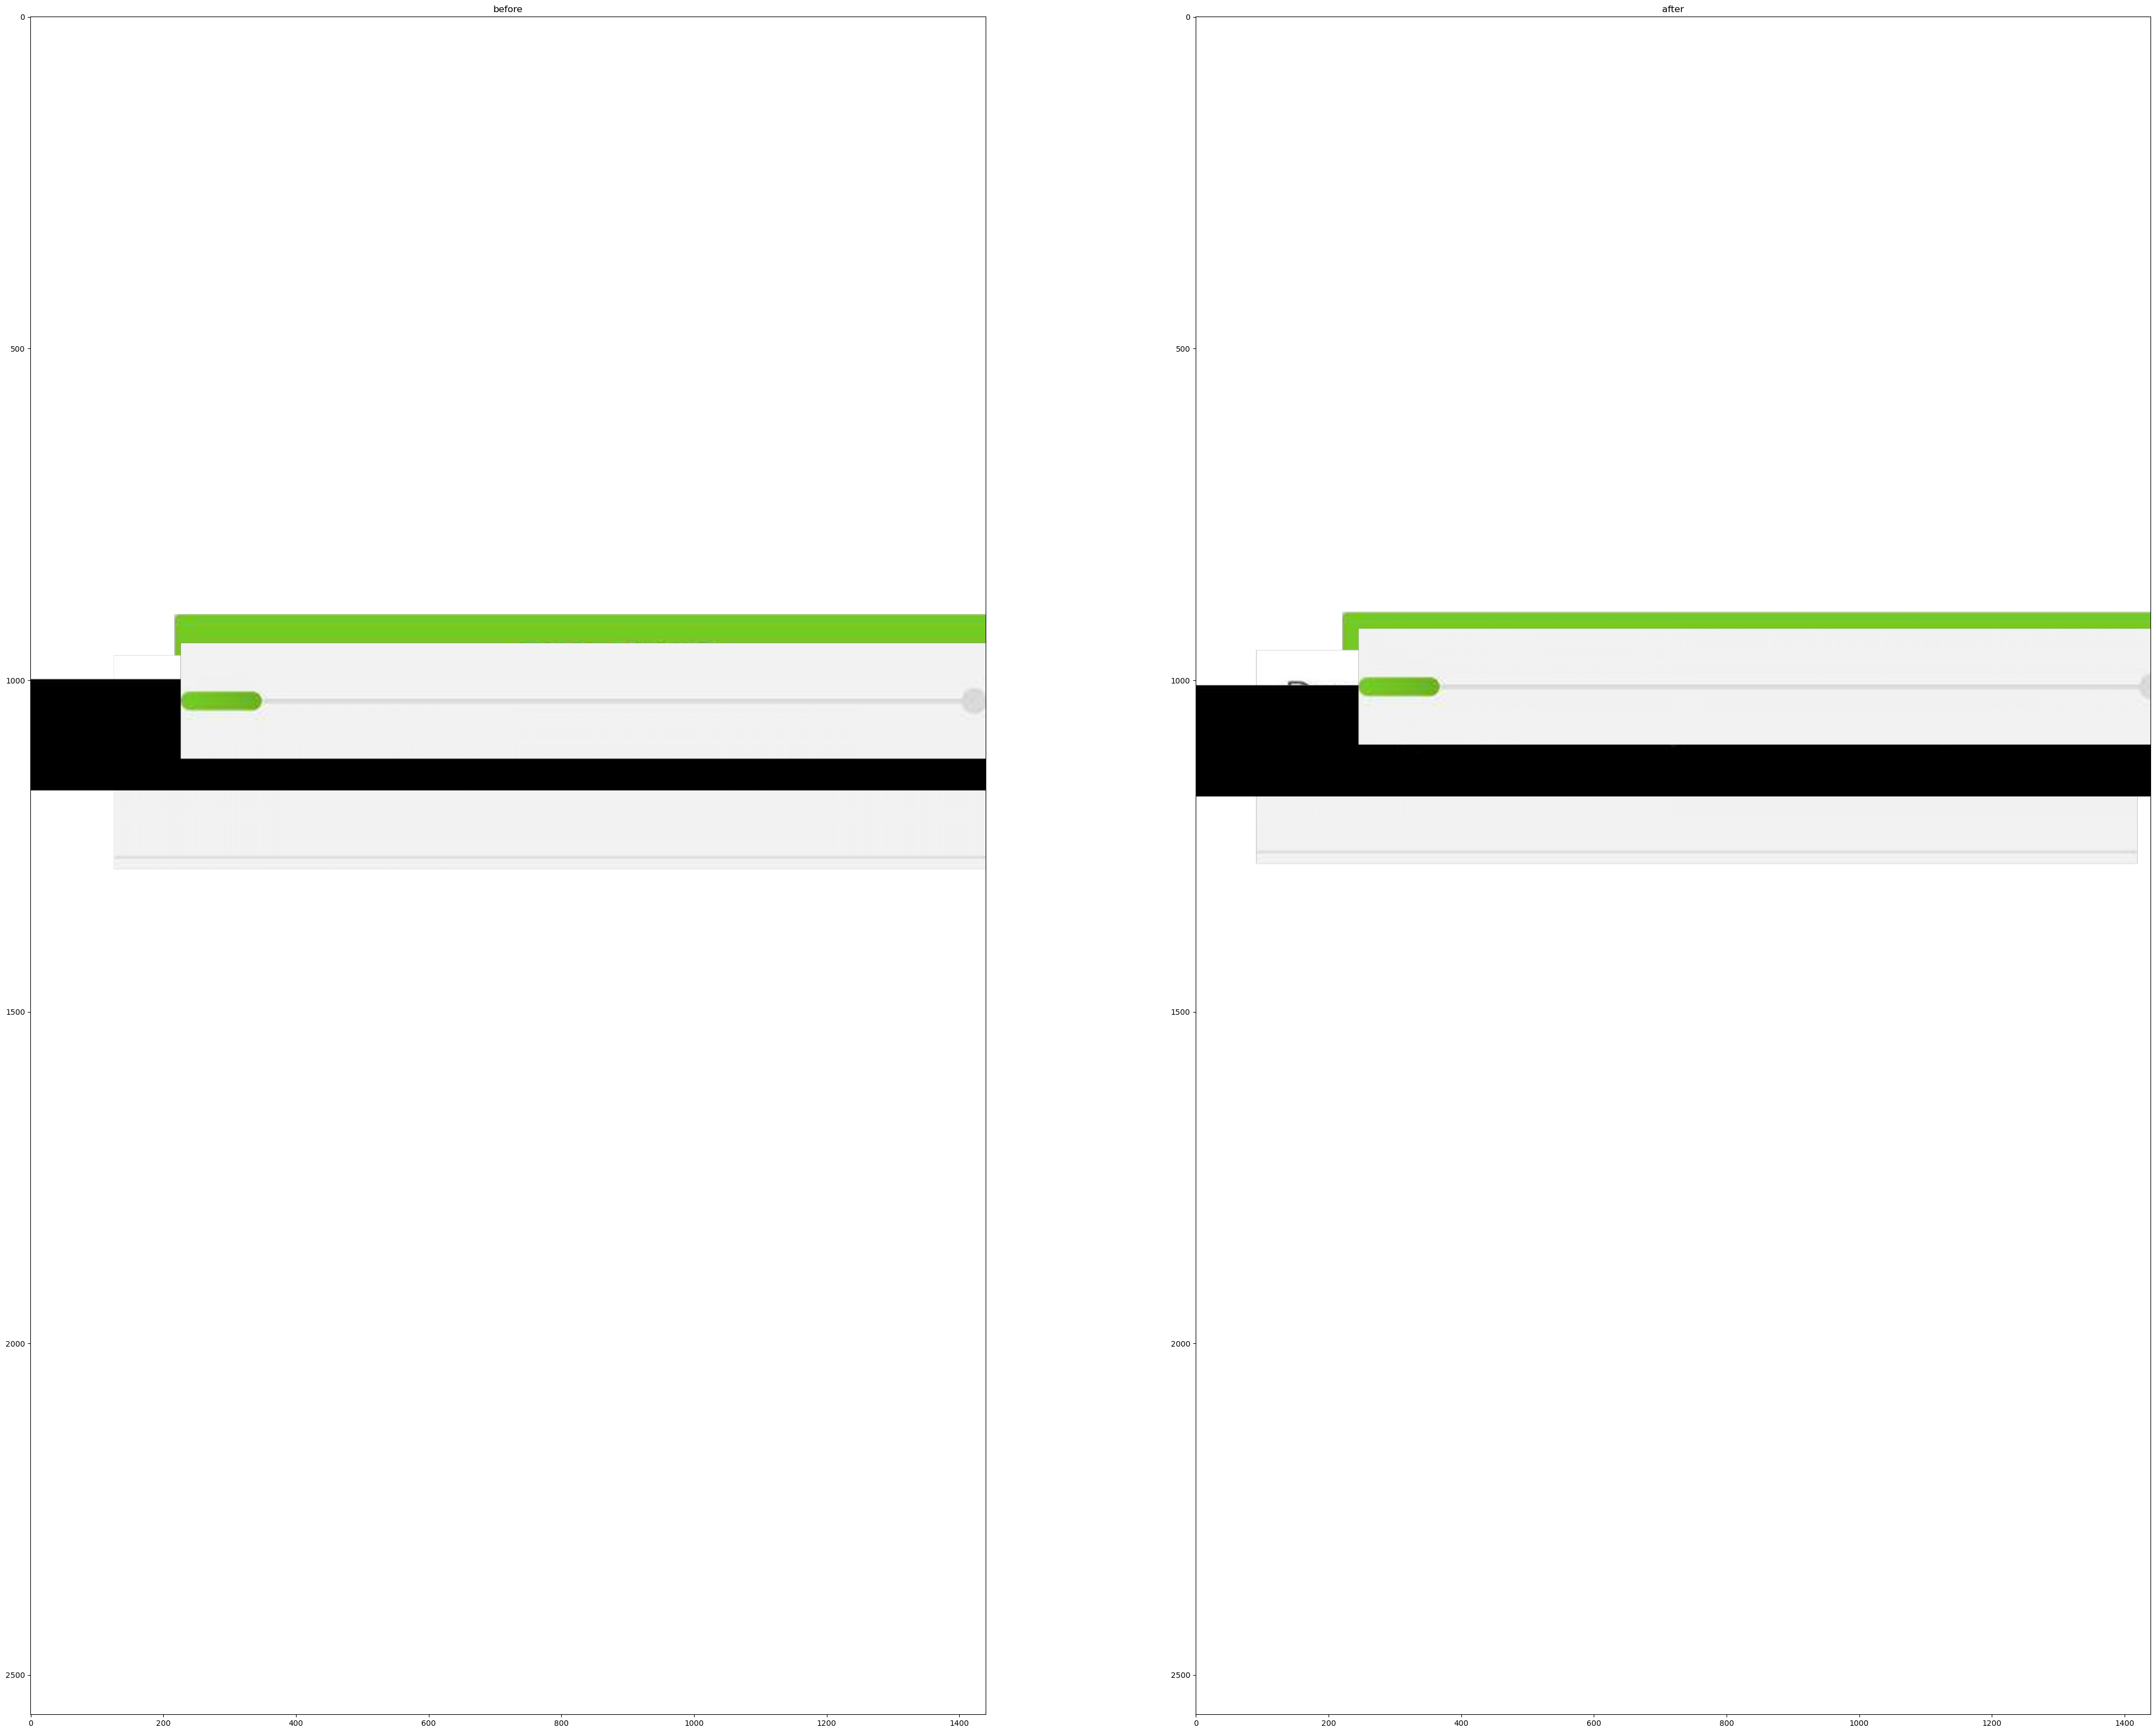

In [197]:
result_pil_after = transform_t_to_pil(img)
fig = plt.figure(figsize=(50,40))
fig.add_subplot(1,2,1)
plt.imshow(result_pil_before)
plt.title("before")
fig.add_subplot(1,2,2)
plt.imshow(result_pil_after)
plt.title("after")
plt.show()

In [159]:
decoded = vae.decode(gd.z)
decoded_denormalised = decoded[:,:,:2] * torch.tensor([NORMAL_UI_DIMENSIONS[0],NORMAL_UI_DIMENSIONS[1]])
decoded_denormalised

tensor([[[ 230.2552,  899.1934],
         [ 367.4311,  970.6765],
         [ 476.6924,  989.6137],
         [ 564.0978, 1002.5051],
         [ 130.9139,  941.8088],
         [ 136.3365,  992.0625],
         [ 209.3241,  946.9811]]], grad_fn=<MulBackward0>)

In [161]:
decoded[:,:,:2]

tensor([[[0.1599, 0.3512],
         [0.2552, 0.3792],
         [0.3310, 0.3866],
         [0.3917, 0.3916],
         [0.0909, 0.3679],
         [0.0947, 0.3875],
         [0.1454, 0.3699]]], grad_fn=<SliceBackward0>)

In [162]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### Use 'old' Aesthetics predictor

In [ ]:
class AestheticPredictor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=0)
        self.global_avg_pooling = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = torch.nn.Linear(32, 4096)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(4096, 1)
        # Download the model from HF Hub
        local_filename = hf_hub_download(repo_id="mowoe/modeling_how_different_user_groups_model", filename="model.pt")
        self.load_state_dict(torch.load(local_filename, map_location="cpu"))
        self.eval()

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
aesthetic_predictor = AestheticPredictor()

In [ ]:
gd_new = GradientDescent(z.detach(), segments, aesthetic_predictor, "cpu")

In [ ]:
scores = []
optimiser_gd_new = torch.optim.AdamW(gd_new.parameters(), lr=0.005)
iters = 5
for x in range(iters):
    score, image, mn_loss, transformed_img = gd_new.forward(vae)
    score = score[0][0]
    loss = -score
    loss += mn_loss[0] # / 100.0
    logger.info(f"[{x+1}/{iters}] aesthetics score: {score}, mn_loss: {mn_loss.item()}(/100), sum: {loss}")
    loss.backward()
    scores.append(loss.item())
    optimiser_gd.step()

In [ ]:
display(transform_t_to_pil(img).resize((int(result_pil_after.size[0]*0.25),int(result_pil_after.size[1]*0.25))))

In [ ]:
def out_of_bounds_loss(normalised_vector):
    return (torch.pow(normalised_vector - 0.5, 10)).mean()

In [ ]:
out_of_bounds_loss(decoded)

In [ ]:
gd.z

In [ ]:
from utils import get_all_bounding_boxes_and_ids

for dataset_idx in range(1000,2000,1):
    with open(test_dataset[dataset_idx][-1].replace(".jpg",".json"), "r") as f:
        img_json = json.load(f)
    img = Image.open(test_dataset[dataset_idx][-1])
    img = img.resize((1440, 2560), Image.Resampling.LANCZOS)
    for bbox, name in get_all_bounding_boxes_and_ids(img_json["activity"]["root"]):
        try:
            if name == "android:id/navigationBarBackground" or name == "android:id/statusBarBackground":
                display(img.crop((bbox[0],bbox[1],bbox[2],bbox[3])))
                print(name)
        except ValueError:
            pass